In [1]:
import os
import zipfile
import pickle
import h5py
import cv2
from google.colab.patches import cv2_imshow
%matplotlib inline

In [2]:
import scipy as sp
import numpy as np
import pandas as pd
import PIL
import scipy.ndimage as spi
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1 for meningioma, 2 for glioma, 3 for pituitary tumor

In [4]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/dataset/BrainTumor",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3064 files belonging to 3 classes.
Using 2452 files for training.
Found 3064 files belonging to 3 classes.
Using 612 files for validation.


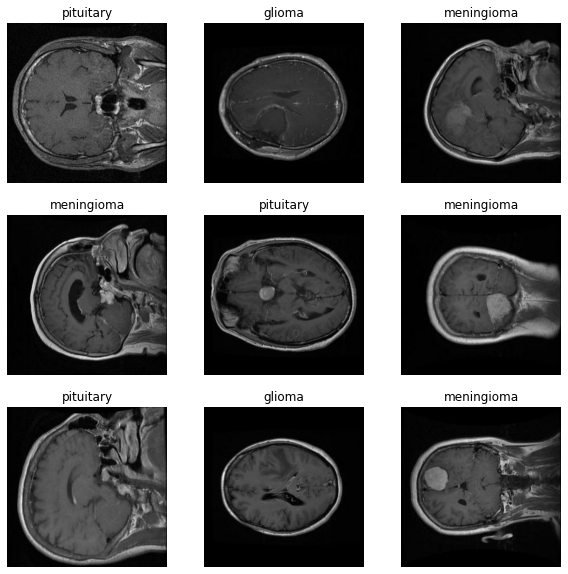

In [5]:
import matplotlib.pyplot as plt
        
class_names = ['glioma', 'meningioma', 'pituitary']
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

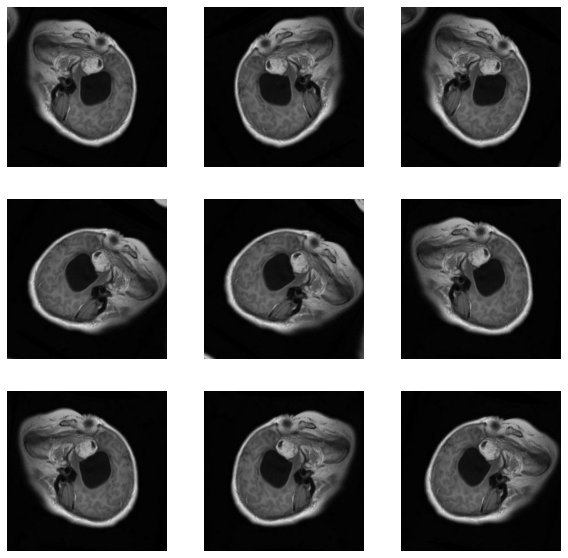

In [7]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)

test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [10]:
train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)

In [11]:
%%time
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
conv_layer_32 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
conv_layer_64 = tf.keras.layers.Conv2D(64,3,activation='relu')
conv_layer_16 = tf.keras.layers.Conv2D(16,3,activation='relu')
max_pool = tf.keras.layers.MaxPooling2D()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

num_classes = 3

model = tf.keras.Sequential([
  normalization_layer,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  conv_layer_32,
  max_pool,
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
77/77 [==============================] - 167s 2s/step - loss: 2.0297 - accuracy: 0.6191 - val_loss: 0.7808 - val_accuracy: 0.6777
Epoch 2/10
77/77 [==============================] - 24s 310ms/step - loss: 0.6140 - accuracy: 0.7365 - val_loss: 0.5772 - val_accuracy: 0.7521
Epoch 3/10
77/77 [==============================] - 24s 310ms/step - loss: 0.4960 - accuracy: 0.7912 - val_loss: 0.4538 - val_accuracy: 0.7913
Epoch 4/10
77/77 [==============================] - 24s 311ms/step - loss: 0.4220 - accuracy: 0.8222 - val_loss: 0.4012 - val_accuracy: 0.8244
Epoch 5/10
77/77 [==============================] - 25s 314ms/step - loss: 0.3854 - accuracy: 0.8356 - val_loss: 0.3321 - val_accuracy: 0.8388
Epoch 6/10
77/77 [==============================] - 24s 312ms/step - loss: 0.3443 - accuracy: 0.8511 - val_loss: 0.3176 - val_accuracy: 0.8802
Epoch 7/10
77/77 [==============================] - 24s 310ms/step - loss: 0.3106 - accuracy: 0.8736 - val_loss: 0.3863 - val_accuracy: 0.8223
E

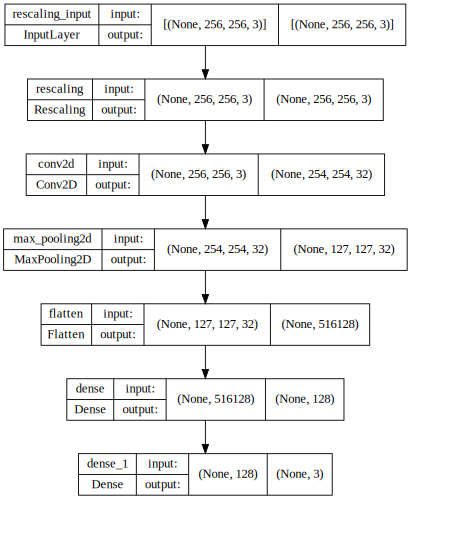

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 516128)            0         
                                                                 
 dense (Dense)               (None, 128)               66064512  
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                      

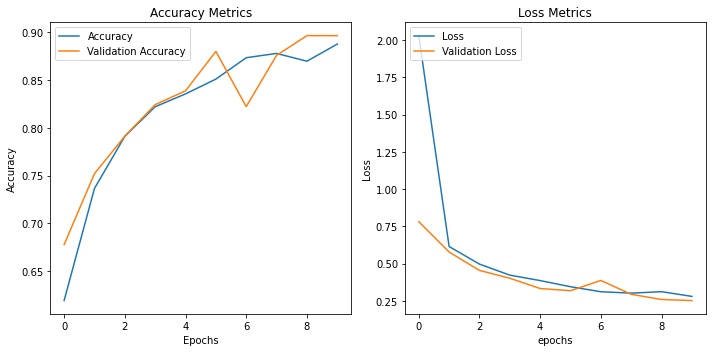

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = 10
epochs_range = range(0, epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[0]
ax2 = axes[1]
ax1 = plt.subplot(1,2,1)
      
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy Metrics")
ax1.plot(epochs_range, acc)
ax1.plot(epochs_range, val_acc)
ax1.legend(["Accuracy", "Validation Accuracy"], loc ="upper left")
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = 10
epochs_range = range(0, epochs)

ax2.set_xlabel("epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss Metrics")
ax2.plot(epochs_range, loss)
ax2.plot(epochs_range, val_loss)
ax2.legend(["Loss", "Validation Loss"], loc ="upper left")

fig.tight_layout()

In [15]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Colab Notebooks/dataset/yes/y1002.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
predictions = model.predict(img_array)
score = predictions[0]
print(score)





[-29.400278 -33.093685  25.152592]


In [16]:
%cd /content/drive/MyDrive/Colab Notebooks/
model.save('model_cnn_multi-classification.h5')
    

/content/drive/MyDrive/Colab Notebooks


In [17]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 58ms/step - loss: 0.2191 - accuracy: 0.8906
Test accuracy : 0.890625


In [18]:
labels_entire = []
pred_entire = []
for image_batch,label_batch in test_ds.as_numpy_iterator():
    prediction = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(prediction).numpy()

    n = 0
    predict = []
    while n<=(predictions.shape[0]-3):
        pred = np.argmax(predictions[n:n+3]) #Returns the index of the largest element in the selected subarray
        n+=3
        pred_entire.append(pred)
    for el in label_batch:
        labels_entire.append(el)
pred_entire = np.array(pred_entire)
labels_entire = np.array(labels_entire)
print(pred_entire)
print(labels_entire)

[0 1 0 1 1 2 1 2 0 2 0 2 2 2 1 0 2 0 2 1 2 2 0 0 0 0 2 2 1 0 0 2 2 1 1 1 0
 0 0 2 1 2 0 1 1 0 1 2 0 1 0 0 0 1 0 0 2 0 2 0 0 0 1 2 2 1 1 0 1 0 0 0 0 2
 2 2 0 1 2 1 1 2 2 0 0 0 0 0 0 2 1 2 2 2 0 0 0 0 0 0 2 2 2 1 2 1 0 1 0 0 0
 0 2 2 2 0 0 0 2 0 0 2 2 2 2 0 0 0]
[0 1 0 1 1 2 1 2 1 2 0 2 2 2 1 0 2 0 2 1 2 2 0 0 1 0 2 2 1 0 0 2 2 1 1 1 0
 0 0 2 1 2 0 1 1 0 1 2 0 0 0 0 0 1 0 0 2 0 2 0 0 0 1 2 2 1 0 0 1 0 0 0 1 2
 2 2 0 2 2 0 1 2 2 0 0 0 0 1 0 2 0 2 2 2 0 0 1 0 0 0 2 2 2 1 2 1 1 1 0 0 0
 0 2 2 2 1 0 0 2 0 0 2 2 2 2 1 0 0]


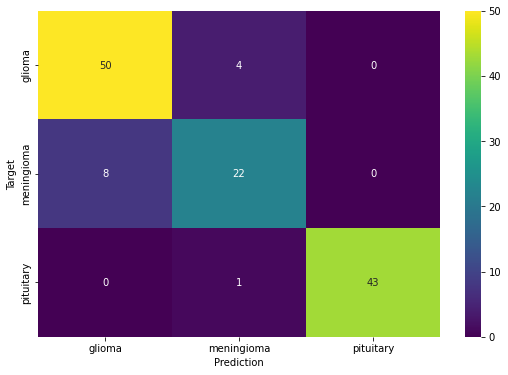

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
%matplotlib inline

arr = confusion_matrix(labels_entire, pred_entire)
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='viridis')
plt.xlabel("Prediction")
plt.ylabel("Target")
plt.show()

In [21]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(labels_entire, pred_entire, pos_label=2)
metrics.auc(fpr, tpr)

0.9964826839826839